In [ ]:
import os
import glob
from pathlib import Path
!pip install catboost
import numpy as np
import pandas as pd
import cv2
from PIL import Image

import matplotlib.pyplot as plt
# import seaborn as sns  # Uncomment if you use seaborn elsewhere

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    LabelEncoder
)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    roc_auc_score,
    roc_curve,
    mean_squared_error,
    r2_score
)

# TensorFlow / Keras imports
import tensorflow as tf
from tensorflow.keras import backend as K, regularizers, models, layers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten,
    Conv2D, MaxPool2D, BatchNormalization,
    Permute, TimeDistributed,
    Bidirectional, GRU, SimpleRNN, LSTM,
    GlobalAveragePooling2D, SeparableConv2D
)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3
from tensorflow.keras.utils import to_categorical, plot_model

# Traditional ML classifiers
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

from sklearn.linear_model import (
    LogisticRegression, LinearRegression,
    Ridge, RidgeCV, Lasso, LassoCV,
    ElasticNet, ElasticNetCV
)
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    GradientBoostingClassifier, GradientBoostingRegressor,
    BaggingRegressor
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression

# Suppress warnings
from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=UserWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from pathlib import Path
import shutil
import kagglehub

# 1. Set your target path
Fire_Dataset_Path = Path("../input/fire-dataset/fire_dataset")
Fire_Dataset_Path.mkdir(parents=True, exist_ok=True)

# 2. Download the latest version of the Kaggle dataset
dl_path = kagglehub.dataset_download("phylake1337/fire-dataset")
print("kagglehub returned:", dl_path)

# 3. If it’s a zip file, extract; if it’s a directory, copy
dl_path = Path(dl_path)
if dl_path.is_file() and dl_path.suffix == ".zip":
    import zipfile
    with zipfile.ZipFile(dl_path, "r") as zf:
        zf.extractall(Fire_Dataset_Path)
    print("Extracted ZIP into:", Fire_Dataset_Path)
elif dl_path.is_dir():
    # Copy all contents from the downloaded directory into your target folder
    for item in dl_path.iterdir():
        dest = Fire_Dataset_Path / item.name
        if item.is_dir():
            shutil.copytree(item, dest, dirs_exist_ok=True)
        else:
            shutil.copy2(item, dest)
    print(f"Copied dataset directory contents into: {Fire_Dataset_Path}")
else:
    raise RuntimeError(f"Unexpected download result: {dl_path!r}")

# 4. (Optional) Clean up cache if you like—note this removes all versions!
cache_root = Path.home() / ".cache" / "kagglehub" / "datasets" / "phylake1337" / "fire-dataset"
if cache_root.exists():
    shutil.rmtree(cache_root)
    print("Cleaned kagglehub cache for this dataset.")


100%|██████████| 387M/387M [00:03<00:00, 112MB/s]

Extracting files...


kagglehub returned: /root/.cache/kagglehub/datasets/phylake1337/fire-dataset/versions/1
Copied dataset directory contents into: ../input/fire-dataset/fire_dataset
Cleaned kagglehub cache for this dataset.


In [ ]:
PNG_Path = list(Fire_Dataset_Path.glob(r"*/*.png"))

In [ ]:
PNG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],PNG_Path))

In [ ]:
print("FIRE: ", PNG_Labels.count("fire_images"))
print("NO_FIRE: ", PNG_Labels.count("non_fire_images"))

FIRE:  0
NO_FIRE:  0


In [ ]:
PNG_Path_Series = pd.Series(PNG_Path,name="PNG").astype(str)
PNG_Labels_Series = pd.Series(PNG_Labels,name="CATEGORY")

In [ ]:
print(PNG_Path_Series)

Series([], Name: PNG, dtype: object)


In [ ]:
print(PNG_Labels_Series)

Series([], Name: CATEGORY, dtype: object)


In [ ]:
PNG_Labels_Series.replace({"non_fire_images":"NO_FIRE","fire_images":"FIRE"},inplace=True)

In [ ]:
print(PNG_Labels_Series)

Series([], Name: CATEGORY, dtype: object)


In [ ]:
Main_Train_Data = pd.concat([PNG_Path_Series,PNG_Labels_Series],axis=1)

In [ ]:
print(Main_Train_Data.head(-1))

Empty DataFrame
Columns: [PNG, CATEGORY]
Index: []


In [ ]:
Main_Train_Data = Main_Train_Data.sample(frac=1).reset_index(drop=True)

In [ ]:
print(Main_Train_Data.head(-1))

Empty DataFrame
Columns: [PNG, CATEGORY]
Index: []


In [ ]:
import random

# 1. Inspect the DataFrame size
n_rows = len(Main_Train_Data)
print("Number of rows in Main_Train_Data:", n_rows)
print("Valid iloc indices: 0 through", n_rows - 1)

# 2. If non-empty, print first, middle, and last rows
if n_rows > 0:
    # First row
    print("\n--- First row ---")
    print("PNG     :", Main_Train_Data.iloc[0]["PNG"])
    print("CATEGORY:", Main_Train_Data.iloc[0]["CATEGORY"])

    # Middle row
    mid = n_rows // 2
    print("\n--- Middle row ---")
    print("PNG     :", Main_Train_Data.iloc[mid]["PNG"])
    print("CATEGORY:", Main_Train_Data.iloc[mid]["CATEGORY"])

    # Last row
    print("\n--- Last row ---")
    print("PNG     :", Main_Train_Data.iloc[-1]["PNG"])
    print("CATEGORY:", Main_Train_Data.iloc[-1]["CATEGORY"])
else:
    print("The DataFrame is empty. No rows to display.")

# 3. Randomly sample k rows for spot-checking
k = 5  # number of samples
print(f"\n--- Random sample of {k} rows ---")
if n_rows >= k:
    sample_positions = random.sample(range(n_rows), k)
    for pos in sample_positions:
        png_val = Main_Train_Data.iloc[pos]["PNG"]
        cat_val = Main_Train_Data.iloc[pos]["CATEGORY"]
        print(f"Row {pos}: PNG = {png_val}, CATEGORY = {cat_val}")
else:
    print(f"Cannot sample {k} rows; DataFrame only has {n_rows} rows.")


Number of rows in Main_Train_Data: 0
Valid iloc indices: 0 through -1
The DataFrame is empty. No rows to display.

--- Random sample of 5 rows ---
Cannot sample 5 rows; DataFrame only has 0 rows.


In [ ]:
remove_PNG = '../input/fire-dataset/fire_dataset/non_fire_images/non_fire.189.png'
Main_Train_Data = Main_Train_Data.loc[~(Main_Train_Data.loc[:,'PNG'] == remove_PNG),:]

In [ ]:
print(Main_Train_Data.loc[Main_Train_Data.loc[:,'PNG'] == remove_PNG,:])

Empty DataFrame
Columns: [PNG, CATEGORY]
Index: []


In [ ]:
print(Main_Train_Data.head(-1))

Empty DataFrame
Columns: [PNG, CATEGORY]
Index: []


In [ ]:
plt.style.use("dark_background")

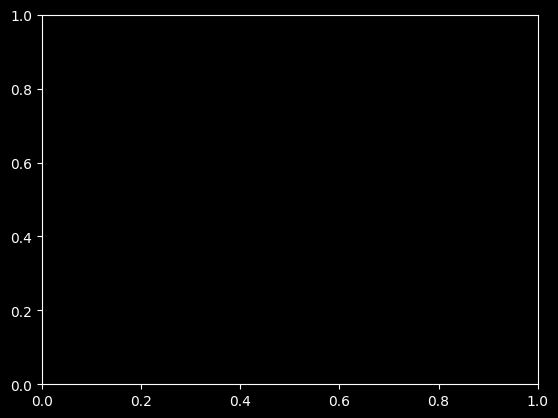

In [ ]:
import seaborn as sns
sns.countplot(Main_Train_Data["CATEGORY"])
plt.show()

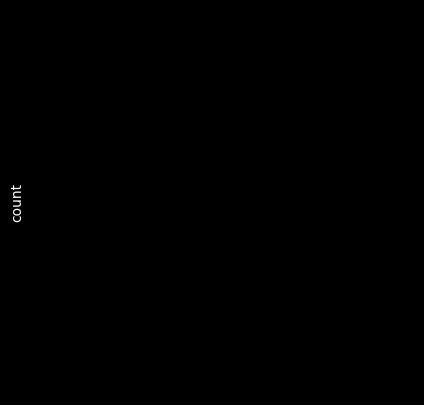

In [ ]:
Main_Train_Data['CATEGORY'].value_counts().plot.pie(figsize=(5,5))
plt.show()

Number of rows in Main_Train_Data: 999

Sample row 0:
 PNG path : ../input/fire-dataset/fire_dataset/fire_dataset/non_fire_images/non_fire.106.png
 CATEGORY : non_fire_images


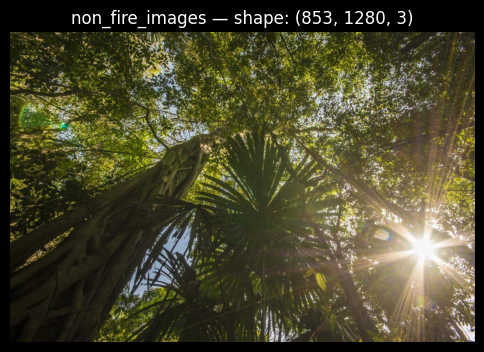

In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

# 1. Define dataset root
dataset_root = Path("../input/fire-dataset/fire_dataset")

# 2. Build the records list
records = []

# Case A: metadata.csv exists
metadata_csv = dataset_root / "metadata.csv"
if metadata_csv.exists():
    meta = pd.read_csv(metadata_csv)
    for _, row in meta.iterrows():
        fn = row["filename"]
        img_path = dataset_root / fn
        if img_path.exists():
            records.append({
                "PNG": str(img_path),
                "CATEGORY": row.get("category", "unknown")
            })

# Case B: No metadata — walk the directory tree
else:
    # glob all PNGs under the root (recursively)
    for img_path in dataset_root.rglob("*.png"):
        # infer category from parent folder name, if it's not the root itself
        parent = img_path.parent
        if parent == dataset_root:
            category = "unknown"
        else:
            category = parent.name
        records.append({
            "PNG": str(img_path),
            "CATEGORY": category
        })

# 3. Create DataFrame
Main_Train_Data = pd.DataFrame(records, columns=["PNG", "CATEGORY"])

# 4. Validate
n_rows = len(Main_Train_Data)
print("Number of rows in Main_Train_Data:", n_rows)
if n_rows == 0:
    raise FileNotFoundError(f"No PNG files found under {dataset_root}.")

# 5. Display a sample image
sample_idx = 0
png_path = Main_Train_Data["PNG"].iloc[sample_idx]
category = Main_Train_Data["CATEGORY"].iloc[sample_idx]

print(f"\nSample row {sample_idx}:")
print(" PNG path :", png_path)
print(" CATEGORY :", category)

img_bgr = cv2.imread(png_path)
if img_bgr is None:
    raise FileNotFoundError(f"Unable to read image at {png_path}")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"{category} — shape: {img_rgb.shape}")
plt.show()


Text(0.5, 1.0, 'fire_images')

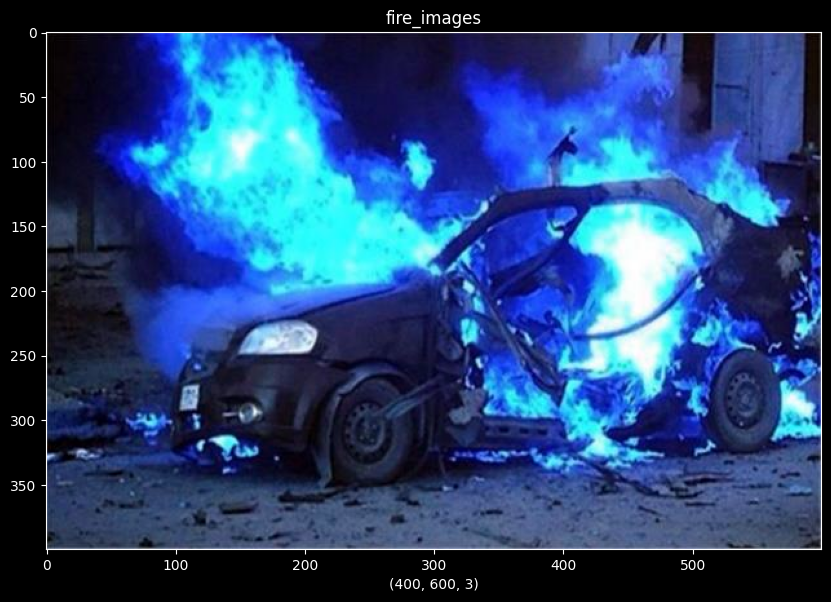

In [ ]:
figure = plt.figure(figsize=(10,10))
x = cv2.imread(Main_Train_Data["PNG"][993])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(Main_Train_Data["CATEGORY"][993])

Text(0.5, 1.0, 'non_fire_images')

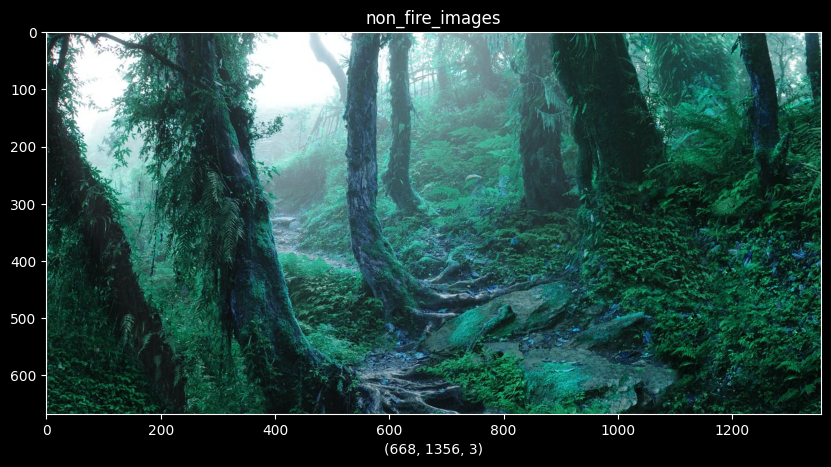

In [ ]:
figure = plt.figure(figsize=(10,10))
x = cv2.imread(Main_Train_Data["PNG"][20])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(Main_Train_Data["CATEGORY"][20])

Text(0.5, 1.0, 'non_fire_images')

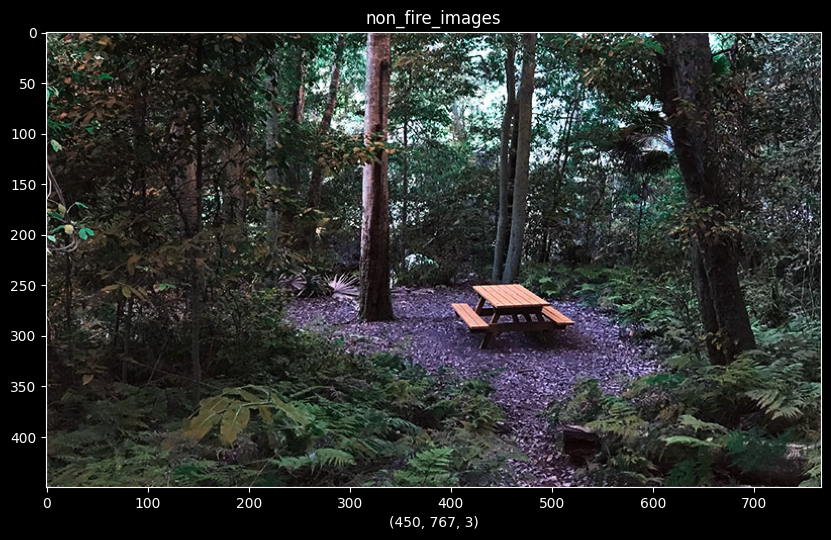

In [ ]:
figure = plt.figure(figsize=(10,10))
x = cv2.imread(Main_Train_Data["PNG"][48])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(Main_Train_Data["CATEGORY"][48])

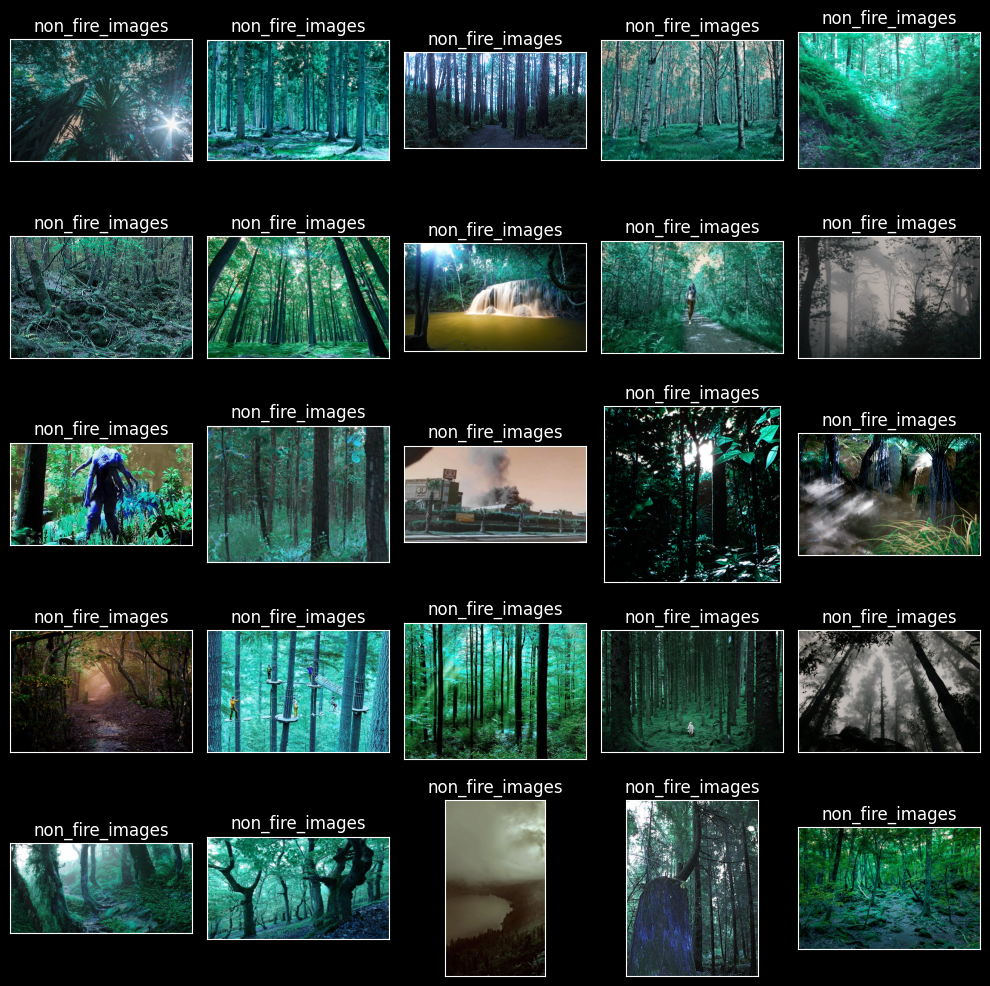

In [ ]:
fig, axes = plt.subplots(nrows=5,
                        ncols=5,
                        figsize=(10,10),
                        subplot_kw={"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(cv2.imread(Main_Train_Data["PNG"][i]))
    ax.set_title(Main_Train_Data["CATEGORY"][i])
plt.tight_layout()
plt.show()

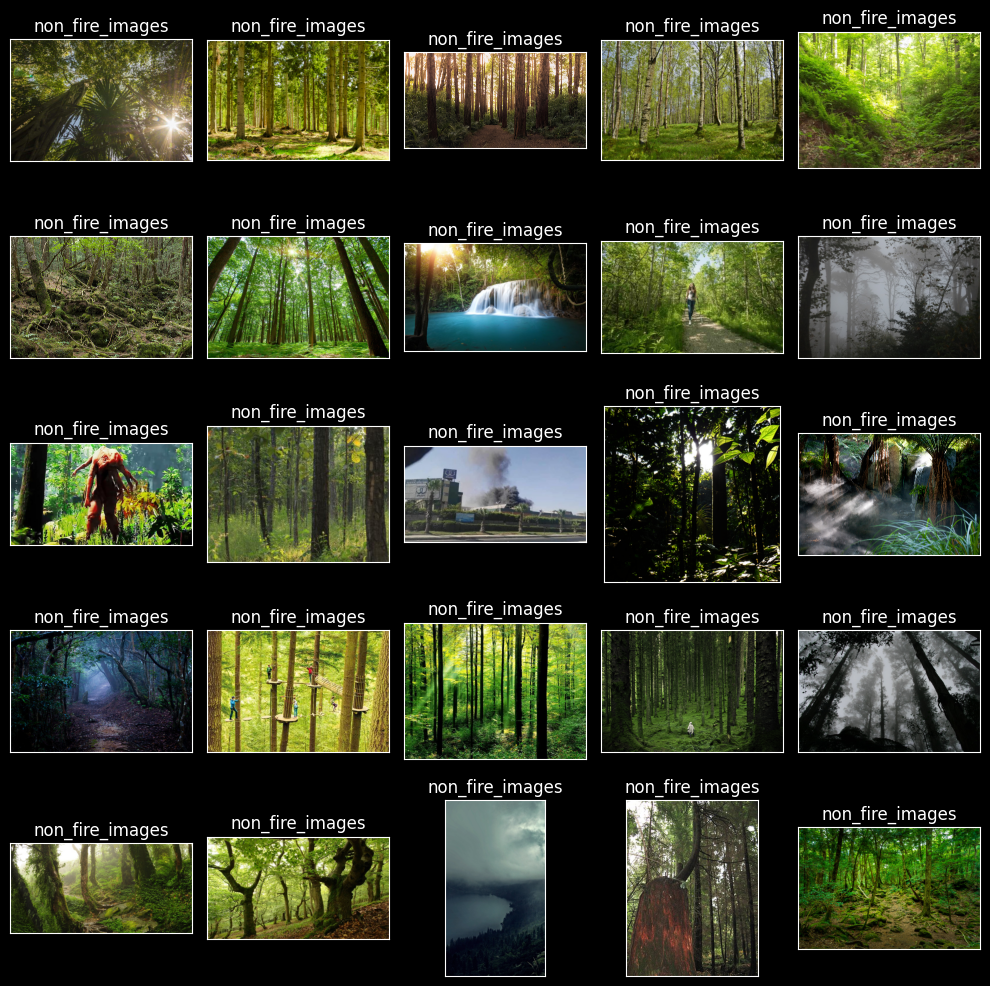

In [ ]:
fig, axes = plt.subplots(nrows=5,
                        ncols=5,
                        figsize=(10,10),
                        subplot_kw={"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    x = cv2.imread(Main_Train_Data["PNG"][i])
    x = cv2.cvtColor(x,cv2.COLOR_RGB2BGR)
    ax.imshow(x)
    ax.set_title(Main_Train_Data["CATEGORY"][i])
plt.tight_layout()
plt.show()

In [ ]:
Train_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)

In [ ]:
Test_Generator = ImageDataGenerator(rescale=1./255)

In [ ]:
Train_Data,Test_Data = train_test_split(Main_Train_Data,train_size=0.9,random_state=42,shuffle=True)

In [ ]:
print("TRAIN SHAPE: ",Train_Data.shape)
print("TEST SHAPE: ",Test_Data.shape)

TRAIN SHAPE:  (899, 2)
TEST SHAPE:  (100, 2)


In [ ]:
print(Train_Data.head(-1))
print("----"*20)
print(Test_Data.head(-1))

                                                   PNG         CATEGORY
599  ../input/fire-dataset/fire_dataset/fire_datase...      fire_images
432  ../input/fire-dataset/fire_dataset/fire_datase...      fire_images
221  ../input/fire-dataset/fire_dataset/fire_datase...  non_fire_images
973  ../input/fire-dataset/fire_dataset/fire_datase...      fire_images
525  ../input/fire-dataset/fire_dataset/fire_datase...      fire_images
..                                                 ...              ...
71   ../input/fire-dataset/fire_dataset/fire_datase...  non_fire_images
106  ../input/fire-dataset/fire_dataset/fire_datase...  non_fire_images
270  ../input/fire-dataset/fire_dataset/fire_datase...      fire_images
860  ../input/fire-dataset/fire_dataset/fire_datase...      fire_images
435  ../input/fire-dataset/fire_dataset/fire_datase...      fire_images

[898 rows x 2 columns]
--------------------------------------------------------------------------------
                               

In [ ]:
print(Test_Data["CATEGORY"].value_counts())

CATEGORY
fire_images        79
non_fire_images    21
Name: count, dtype: int64


In [ ]:
encode = LabelEncoder()

In [ ]:
For_Prediction_Class = encode.fit_transform(Test_Data["CATEGORY"])

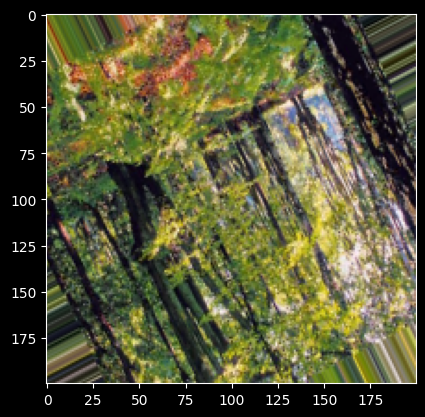

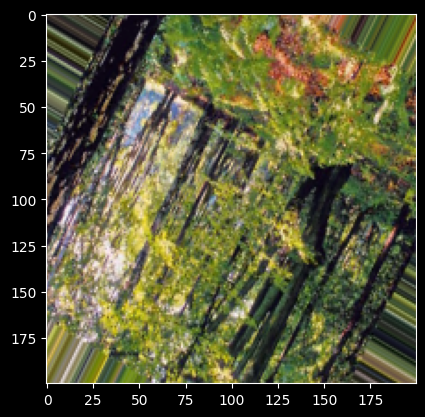

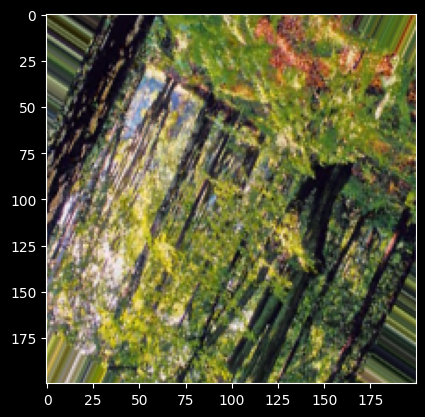

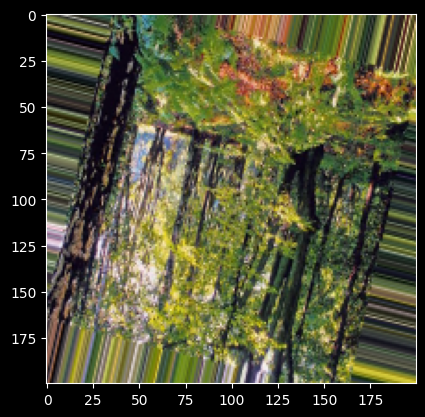

In [ ]:
example_Image = Train_Data["PNG"][99]
Load_Image = image.load_img(example_Image,target_size=(200,200))
Array_Image = image.img_to_array(Load_Image)
Array_Image = Array_Image.reshape((1,) + Array_Image.shape)

i = 0
for batch in Train_Generator.flow(Array_Image,batch_size=1):
    plt.figure(i)
    IMG = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [ ]:
Train_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=Train_Data,
                                                   x_col="PNG",
                                                   y_col="CATEGORY",
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   batch_size=32,
                                                   subset="training")

Found 810 validated image filenames belonging to 2 classes.


In [ ]:
Validation_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=Train_Data,
                                                   x_col="PNG",
                                                   y_col="CATEGORY",
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   batch_size=32,
                                                   subset="validation")

Found 89 validated image filenames belonging to 2 classes.


In [ ]:
Test_IMG_Set = Test_Generator.flow_from_dataframe(dataframe=Test_Data,
                                                 x_col="PNG",
                                                 y_col="CATEGORY",
                                                 color_mode="rgb",
                                                 class_mode="categorical",
                                                 batch_size=32)

Found 100 validated image filenames belonging to 2 classes.


In [ ]:
for data_batch,label_batch in Train_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (32, 256, 256, 3)
LABEL SHAPE:  (32, 2)


In [ ]:
for data_batch,label_batch in Validation_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (32, 256, 256, 3)
LABEL SHAPE:  (32, 2)


In [ ]:
for data_batch,label_batch in Test_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (32, 256, 256, 3)
LABEL SHAPE:  (32, 2)


In [ ]:
print("TRAIN: ")
print(Train_IMG_Set.class_indices)
print(Train_IMG_Set.classes[0:5])
print(Train_IMG_Set.image_shape)
print("---"*20)
print("VALIDATION: ")
print(Validation_IMG_Set.class_indices)
print(Validation_IMG_Set.classes[0:5])
print(Validation_IMG_Set.image_shape)
print("---"*20)
print("TEST: ")
print(Test_IMG_Set.class_indices)
print(Test_IMG_Set.classes[0:5])
print(Test_IMG_Set.image_shape)

TRAIN: 
{'fire_images': 0, 'non_fire_images': 1}
[0, 0, 0, 0, 1]
(256, 256, 3)
------------------------------------------------------------
VALIDATION: 
{'fire_images': 0, 'non_fire_images': 1}
[0, 0, 1, 0, 0]
(256, 256, 3)
------------------------------------------------------------
TEST: 
{'fire_images': 0, 'non_fire_images': 1}
[0, 0, 1, 0, 0]
(256, 256, 3)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, MaxPooling2D,
    Dropout, Flatten, Dense
)

# Build the model
Model = Sequential()

Model.add(Conv2D(
    filters=32,
    kernel_size=(3, 3),
    activation="relu",
    input_shape=(256, 256, 3)
))
Model.add(BatchNormalization())
Model.add(MaxPooling2D((2, 2)))

Model.add(Conv2D(
    filters=64,
    kernel_size=(3, 3),
    activation="relu",
    padding="same"
))
Model.add(Dropout(0.2))
Model.add(MaxPooling2D((2, 2)))

Model.add(Conv2D(
    filters=128,
    kernel_size=(3, 3),
    activation="relu",
    padding="same"
))
Model.add(Dropout(0.5))
Model.add(MaxPooling2D((2, 2)))

Model.add(Flatten())
Model.add(Dense(256, activation="relu"))
Model.add(Dropout(0.5))
Model.add(Dense(1, activation="sigmoid"))

# (Optional) Print the model summary to verify
Model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 127, 127, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 63, 63, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    31,490,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,583,937 (120.48 MB)

 Trainable params: 31,583,873 (120.48 MB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
Call_Back = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=5,mode="min")

In [ ]:
Model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, MaxPooling2D,
    Dropout, Flatten, Dense
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Locate all PNGs and build a DataFrame
dataset_root = Path("../input/fire-dataset/fire_dataset")
records = []
for img_path in dataset_root.rglob("*.png"):
    category = img_path.parent.name if img_path.parent != dataset_root else "unknown"
    records.append({
        "filename": str(img_path),
        "CATEGORY": category
    })

df = pd.DataFrame(records)
if df.empty:
    raise FileNotFoundError(f"No PNG files found under {dataset_root}")

# 2. Split into train/validation
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["CATEGORY"],
    random_state=42
)

print(f"Training samples:   {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# 3. ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

# 4. Generators from DataFrame
Train_IMG_Set = train_datagen.flow_from_dataframe(
    train_df, x_col="filename", y_col="CATEGORY",
    target_size=(256, 256), class_mode="binary",
    batch_size=32, shuffle=True
)
Validation_IMG_Set = val_datagen.flow_from_dataframe(
    val_df, x_col="filename", y_col="CATEGORY",
    target_size=(256, 256), class_mode="binary",
    batch_size=32, shuffle=False
)

# 5. Build the CNN
Model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation="relu", padding="same"),
    Dropout(0.2),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation="relu", padding="same"),
    Dropout(0.5),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

# 6. Compile with the closing quote fixed
Model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# 7. Callbacks
Call_Back = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("best_fire_model.h5", save_best_only=True)
]

# 8. Train
CNN_Model = Model.fit(
    Train_IMG_Set,
    validation_data=Validation_IMG_Set,
    callbacks=Call_Back,
    epochs=50
)


Training samples:   799
Validation samples: 200
Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6803 - loss: 16.6456

25/25 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6853 - loss: 16.2557 - val_accuracy: 0.7550 - val_loss: 0.5652
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - accuracy: 0.9333 - loss: 0.2041

25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9325 - loss: 0.2057 - val_accuracy: 0.7550 - val_loss: 0.4429
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - accuracy: 0.9277 - loss: 0.1821

25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9281 - loss: 0.1817 - val_accuracy: 0.7700 - val_loss: 0.3325
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9563 - loss: 0.1129 - val_accuracy: 0.7800 - val_loss: 0.3884
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9427 - loss: 0.1829 - val_accuracy: 0.8100 - val_loss: 0.3658
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9668 - loss: 0.1509 - val_accuracy: 0.7850 - val_loss: 0.3606
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9416 - loss: 0.1652 - val_accuracy: 0.9200 - val_loss: 0.4438
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9556 - loss: 0.1289 - val_accuracy: 0.7900 - val_loss: 0.3476
